In [126]:
include("../code/headers.jl")

In [123]:
n = factorial(8)
k = 3
R = 1 .- 2 ./k
m_ = n*(1 .- R)
m = Int.(round.(m_))
m_

26880.0

In [124]:
randseed = 123
algo = MS(maxiter=1000, Tmax=1, gamma=0.0, sigma=0.0)
Y = [rand([0,1], n) for mm in m]

0-dimensional Array{Array{Int64,1},0}:
[0, 0, 0, 1, 1, 1, 0, 1, 1, 1  …  1, 1, 0, 1, 0, 0, 1, 0, 1, 1]

In [125]:
res = Vector{BPResults{MS}}(undef, length(m))
msgs = [Float64[] for _ in m]
fgs = Vector{FactorGraph}(undef,length(m))
for j in eachindex(m)
    println("Rate $(round(R[j],digits=2)). $j of $(length(m))")
    fg = ldpc_graph(Val(2), n, m[j], randseed=randseed)
    extfields!(fg,Y[j],algo,randseed=randseed+j)
    res[j] = bp!(fg, algo, Y[j], verbose=true)
    msgs[j] = [ms[end] for ms in fg.mfv]
    fgs[j] = deepcopy(fg)
end

Rate 0.33. 1 of 1


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:44


In [109]:
fg = fgs[1]
y = Y[1]
msg = msgs[1]
beliefs = fg.fields;

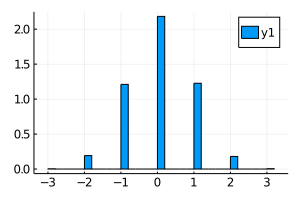

13-element OffsetArray(::Array{Float64,1}, -6:6) with eltype Float64 with indices -6:6:
 0.0
 0.0
 0.0
 0.0006944444444444445
 0.038392857142857145
 0.24211309523809524
 0.4365079365079365
 0.2452876984126984
 0.03601190476190476
 0.000992063492063492
 0.0
 0.0
 0.0

In [110]:
N = 6
p = OffsetArray(zeros(2N+1), -N:N)
for (k,v) in proportionmap(msg_rounded)
    p[k] = v
end
display(histogram(msg_rounded, size=(300,200), normalize=:pdf))
p

$$-F_a = \sum_{i\in\partial a}\left\{ \left|f_{bi}+s_{i}\right|-\left|f_{bi}\right|\right\} -\Theta\left(-\prod_{i\in\partial a}\left(f_{bi}+s_{i}\right)\right)2\min_{i\in\partial a}\left|f_{bi}+s_{i}\right|\\$$
$$-F_i = \left|f_{ai}+f_{bi}+s_{i}\right|-\left|f_{ai}\right|-\left|f_{bi}\right|$$

In [120]:
function free_energy(fg::FactorGraph)
   O = 0.0
    for (a_idx,a) in enumerate(fg.Fneigs)
       F = [fg.fields[i] - fg.mfv[a_idx][i_idx] for (i_idx,i) in enumerate(a)]
       O += sum(abs.(F)) - (prod(F)<0)*2*minimum(abs.(F)) 
    end
    O -= sum(abs.(fg.fields))
end

free_energy (generic function with 1 method)

In [122]:
F = free_energy(fg)
f = F / fg.n
d = 0.5*(1 - f)

0.20897817460223694

In [111]:
# Round messages and check that the noise is still much smaller
msg_rounded = round.(Int, msg)
@show maximum(abs,msg-msg_rounded)
# Source vector in spin format
s = 1 .- 2*y
# First round beliefs, then take their sign
σ_rounded = sign.(round.(Int, beliefs))
# Compute overlap and distortion
ovl_rounded = dot(σ_rounded, s) / n
dist_rounded = 0.5*(1 - ovl_rounded)

maximum(abs, msg - msg_rounded) = 2.84695667041035e-9


0.22888144841269842

In [112]:
function overgen(p,K)
    N = lastindex(p)
    O = 0.0
    S = CartesianIndices(Tuple(fill(0:1,K)))
    for ff in map(Tuple, CartesianIndices(Tuple(fill(-N:N,K))))
        P = prod(p[fi] for fi in ff)
        for fs in map(s -> ff .+ (2 .* Tuple(s) .- 1), S)
            O += P*sum(abs.(fs).-abs.(ff))
            if prod(fs) < 0
                O -= P*2*minimum(abs.(fs))
            end
        end
    end
    O/2^K
end

function overlink(p)
    O = 0.0
    N = lastindex(p)
    for f1=-N:N
        for f2=-N:N
            for s = (-1,1)
                O += p[f1]*p[f2]*0.5*(abs(f1+f2+s)-abs(f1)-abs(f2))
            end
        end
    end
    O
end

overlink (generic function with 1 method)

In [117]:
K = 3
O = overgen(p,K)*2/K-overlink(p)
(1-O)/2

0.20961604713764875

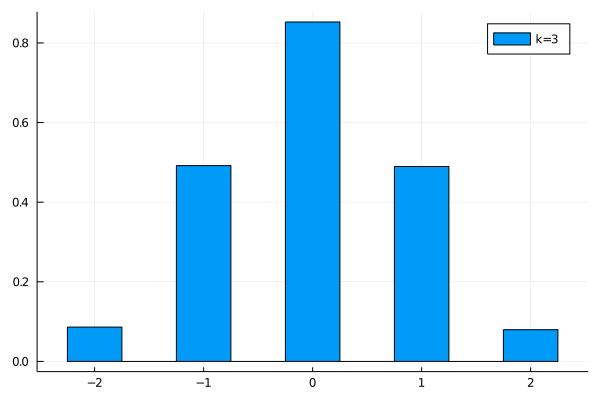

In [114]:
plts = []
bins = -2.25:0.5:2.25
levels = -6:6
cnts = []
dist = zeros(length(m))
for j in eachindex(m)
    push!(plts, histogram(msgs[j], label="k=$(k[j])", bins=bins, normalize=:pdf))
    push!(cnts, OffsetArray(StatsBase.proportions(round.(Int, msgs[j]), levels)))
    dist[j] = distortion(fgs[j], Y[j])
end
# plot(plts..., layout=(2,4), size=(800,400))
plot(plts[1])